In [1]:
import pandas as pd
import numpy as np
from sargas import *
import matplotlib.pyplot as plt

# NVT Simulation

In [2]:
density = 0.5
nparticles = 500
volume = nparticles / density
temperature = 1.0

potential = Potential.lennard_jones(1.0, 1.0)
system = System.insert_particles(nparticles, volume, temperature, 15, 3.0, potential, nparticles, 1000000)

displace_particle = MCMove.displace_particle(0.1, 0.4, nparticles)
mc = MonteCarlo([displace_particle], [1], temperature)

simulation = Simulation.monte_carlo(system, mc, 500)

In [17]:
%%time
print("Equilibration")
simulation.run(nparticles * 1000)

simulation.deactivate_propagator_updates()
props = Observer.properties(100)
simulation.add_observer(props)
widom = Observer.widom_insertion(1)
simulation.add_observer(widom)

print("Production")
simulation.run(nparticles * 5000)

Equilibration
Production
CPU times: user 28.9 s, sys: 59.7 ms, total: 29 s
Wall time: 28.9 s


In [7]:
properties = pd.DataFrame(props.data)

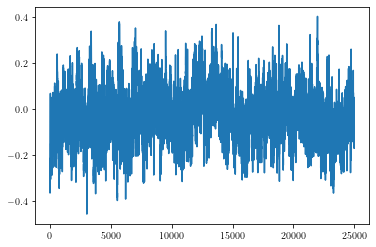

In [8]:
plt.plot(properties.pressure)

In [18]:
wd = pd.DataFrame(widom.data)

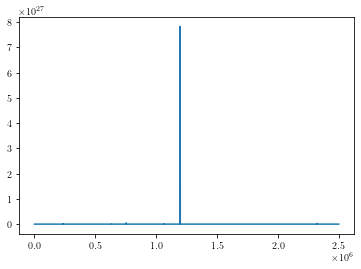

In [19]:
plt.plot(wd.mu)

In [28]:
chemical_potential = -np.log(np.exp(-wd.mu / temperature).mean() / density) * temperature
chemical_potential

-3.847881463934021

# $\mu$VT Simulation

In [29]:
density = 0.5
nparticles = 500
volume = nparticles / density
temperature = 1.0

potential = Potential.lennard_jones(1.0, 1.0)
system = System.insert_particles(nparticles, volume, temperature, chemical_potential, 3.0, potential, nparticles + 100, 1000000)

displace_particle = MCMove.displace_particle(0.1, 0.4, nparticles)
insert_delete_particle = MCMove.insert_delete_particle(chemical_potential)
mc = MonteCarlo([displace_particle, insert_delete_particle], [5, 1], temperature)

simulation = Simulation.monte_carlo(system, mc, 500)

In [30]:
%%time
print("Equilibration")
simulation.run(nparticles * 1000)

simulation.deactivate_propagator_updates()
props = Observer.properties(100)
simulation.add_observer(props)

print("Production")
simulation.run(nparticles * 5000)

Equilibration
Production
CPU times: user 395 ms, sys: 0 ns, total: 395 ms
Wall time: 394 ms


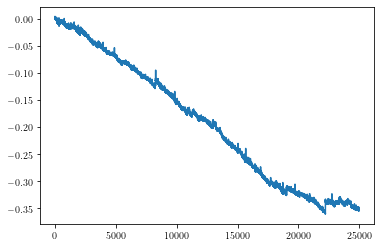

In [31]:
properties = pd.DataFrame(props.data)
plt.plot(properties.pressure)

In [33]:
properties.nparticles

0        2.0
1        1.0
2        3.0
3        4.0
4        1.0
        ... 
24995    1.0
24996    2.0
24997    0.0
24998    2.0
24999    1.0
Name: nparticles, Length: 25000, dtype: float64